# Amazon Alexa Review Sentiment Analysis

## Importing Necessary Libraries

In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FAZEEN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [275]:
%pip install wordcloud
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## EDA: Exploratory Data Analysis

**About the Data**

This dataset consists of a nearly 3000 Amazon customer reviews (input text), star ratings, date of review, variant and feedback of various amazon Alexa products like Alexa Echo, Echo dots, Alexa Firesticks etc. for learning how to train Machine for sentiment analysis.

In [278]:
#load the dataset
df = pd.read_csv("amazon_alexa.tsv",delimiter='\t',quoting=3)
print("Shape of Dataset: ",df.shape)

Shape of Dataset:  (3150, 5)


In [279]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [280]:
#column names
print(f"Feature names: {df.columns.values}")

Feature names: ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [281]:
#check for null values
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

#### There is one record with null value in 'verified review'

In [283]:
#Getting the record where 'verified_reviews' is null 
df[df['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [284]:
#drop the null record
df.dropna(inplace=True)

In [285]:
print(f"Dataset shape after dropping null values : {df.shape}")

Dataset shape after dropping null values : (3149, 5)


In [286]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column
df['length']=df['verified_reviews'].apply(len)

In [287]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [288]:
# randomly checking for the 20th record
print(f"'verified_reviews' column value: {df.iloc[20]['verified_reviews']}")
print(f"Length of review : {len(df.iloc[10]['verified_reviews'])}") #Length of review using len()
print(f"'length' column value : {df.iloc[10]['length']}") #Value of the column 'length

'verified_reviews' column value: Love the Echo and how good the music sounds playing off it. Alexa understands most commands but it is difficult at times for her to find specific playlists or songs on Spotify. She is good with Amazon Music but is lacking in other major programs.
Length of review : 65
'length' column value : 65


#### Hence the length of review is same as the value in the length column 

#### Datatypes of the features

In [291]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

**Conclusion / Insights:**
- Integer values: rating, feedback, length
- String values: date, variation and verified reviews 

In [293]:
len(df)

3149

## Rating Column Analysis

In [295]:
print(f"Rating value count: \n{df['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


### DATA VISUALIZATION

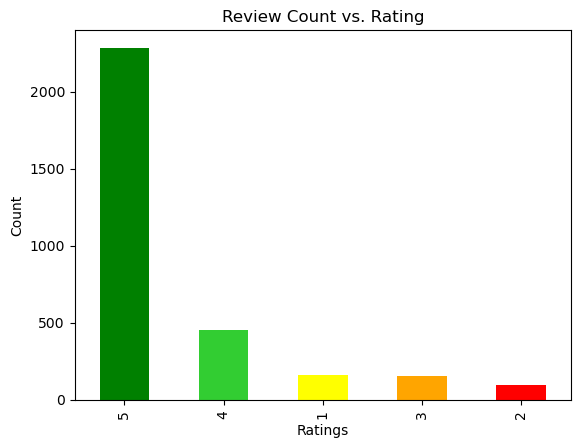

In [297]:
# Bar Plot : Visualize total count of each rating
colors=['green','limegreen','yellow','orange','red']
df['rating'].value_counts().plot.bar(color=colors)
plt.title("Review Count vs. Rating")
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [298]:
# Finding percentage with each rating count
print("Rating - Percentage distribution")
print(round(df['rating'].value_counts()/df.shape[0]*100,2))

Rating - Percentage distribution
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


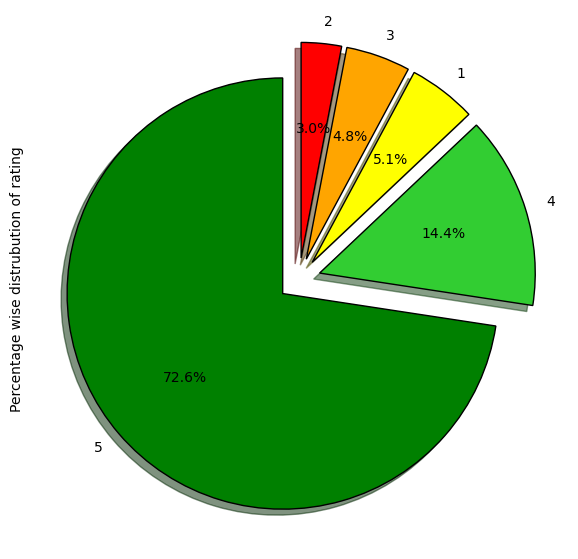

In [299]:
#pie chart
fig = plt.figure(figsize=(7,7))
tags=df['rating'].value_counts()/df.shape[0]
explode=(0.1,0.1,0.1,0.1,0.1)
wp = {'linewidth':1, "edgecolor":'black'}
tags.plot(kind='pie',autopct="%1.1f%%",shadow=True, colors=colors, startangle=90,wedgeprops=wp, explode=explode ,label='Percentage wise distrubution of rating')
plt.show()

## Feedback Column Analysis

In [301]:
print(f"Feedback value count: \n{df['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


#### There are two values in feeback - 0 & 1 : Checking review for each value to see  what kind of review each value corresponds to.

#### for feedback value = 0

In [304]:
review_0 = df[df['feedback']==0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


#### for feedback value = 1

In [306]:
review_1 = df[df['feedback']==1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

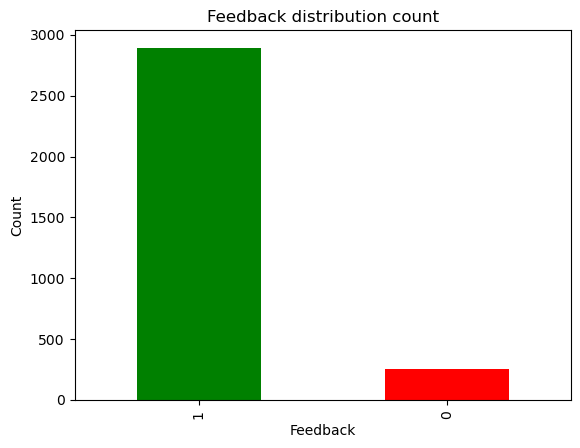

In [308]:
#Bar graph to visualize the total counts of each feedback

df['feedback'].value_counts().plot.bar(color = ['green','red'])
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [309]:
df.shape[0]

3149

In [310]:
print(f"Feedback value count - percentage distribution: \n{round(df['feedback'].value_counts()/df.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


**Conclusion/ Insights:**
- Positive Reviews: 91.87%
- Negative Reviews: 8.13%


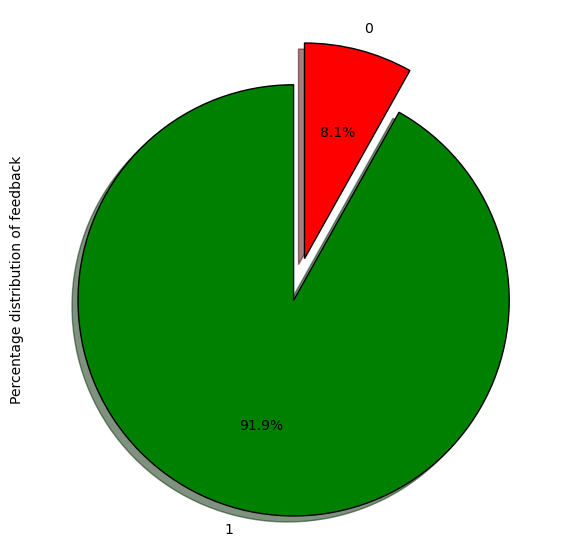

In [312]:
shape = plt.figure(figsize=(7,7))
tags = df['feedback'].value_counts()/df.shape[0]
wp = { 'linewidth': 1, 'edgecolor': 'black'}
explode=(0.1,0.1)
tags.plot(kind='pie',autopct="%1.1f%%",shadow=True, colors = ['green','red'],startangle=90,wedgeprops=wp,explode=explode, label = 'Percentage distribution of feedback')
plt.show()


### Rating values for different feedback

#### For Feedback = 0

In [315]:
df[df['feedback']==0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [316]:
df[df['feedback']==1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

### **Insight:** If rating is 1 or 2 then the feedback is negative and if the rating is 3,4 or 5 then feedback is positive

## 'Variation' Column Analysis

#### This column refers to the variation or type of Amazon Alexa product. Example - Black Dot, Charcoal Fabric etc.

In [320]:
print(f'Variation column Count: \n{df['variation'].value_counts()}')

Variation column Count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


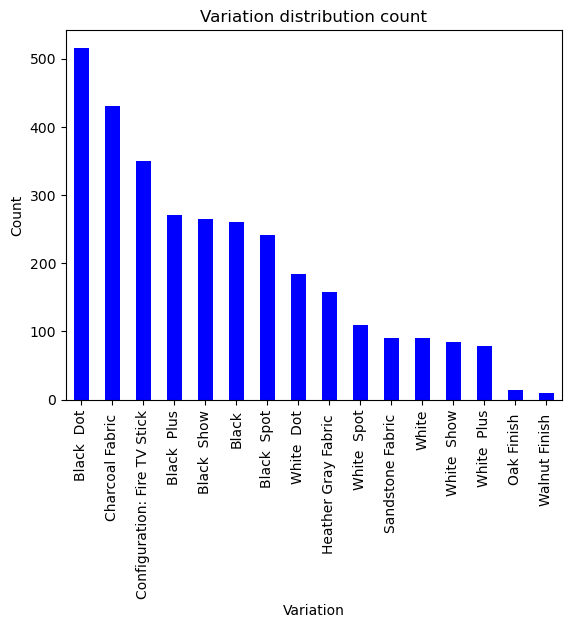

In [321]:
df['variation'].value_counts().plot.bar(color='blue')
plt.title('Variation distribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [322]:
print(f"Variation value count - percentage distribution: \n{round(df['variation'].value_counts()/df.shape[0]*100,2)}")

Variation value count - percentage distribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [323]:
#mean of rating according to variation
df.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

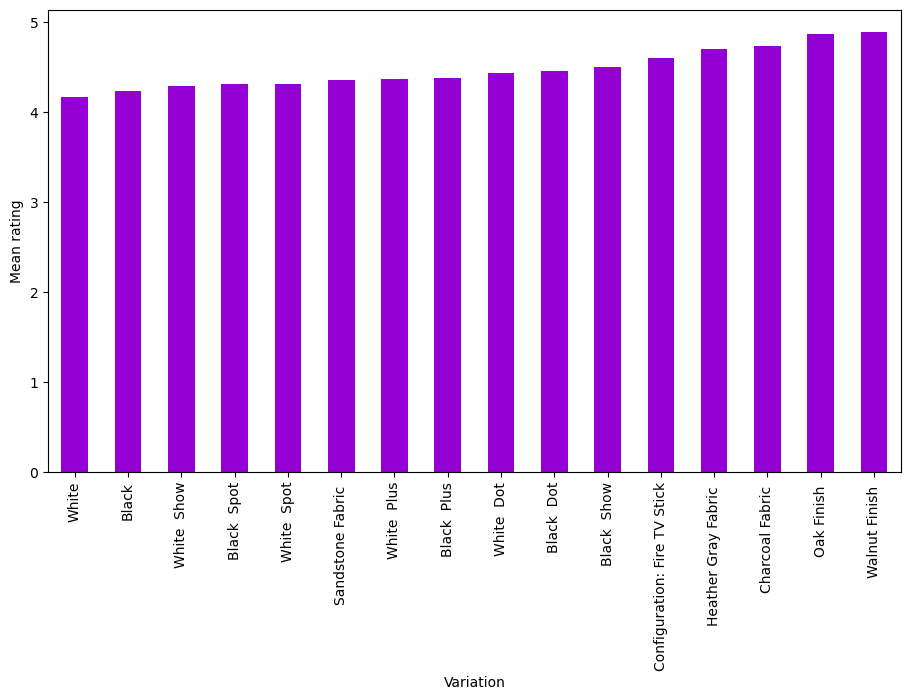

In [324]:
df.groupby('variation')['rating'].mean().sort_values().plot.bar(color='darkviolet',figsize=(11,6))
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

## 'verified_reviews' Column Analysis

In [326]:
df['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

#### Reviews length anlaysis for complete dataset

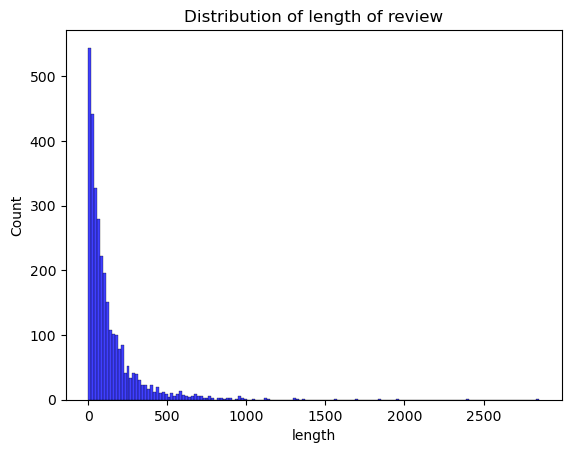

In [328]:
sns.histplot(df['length'],color='blue').set(title='Distribution of length of review')
plt.show()

#### Length analysis when feedback is 0 (negative)

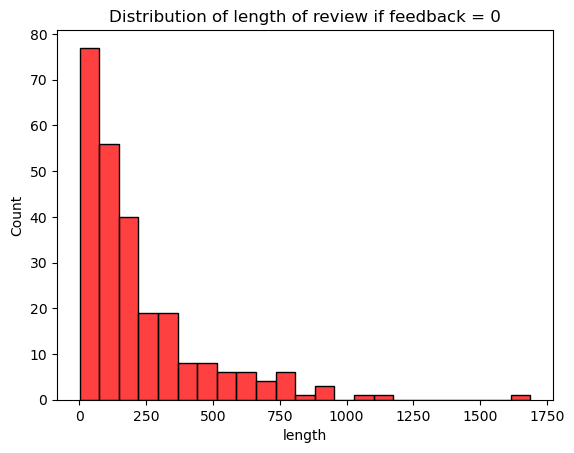

In [330]:
sns.histplot(df[df['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')
plt.show()

#### Length analysis when feedback is 1 (Positive)

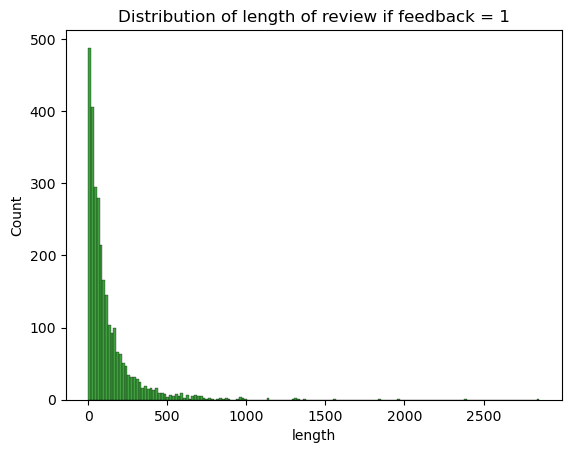

In [332]:
sns.histplot(df[df['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')
plt.show()

**Mean of rating with respect to length**

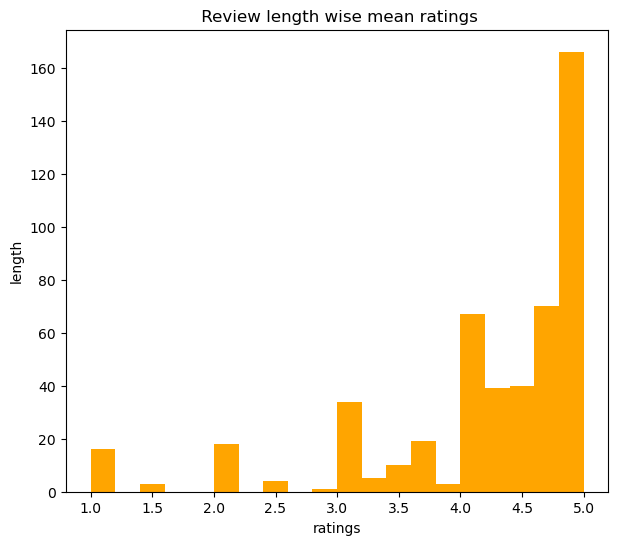

In [334]:
df.groupby('length')['rating'].mean().plot.hist(color='orange',figsize=(7,6), bins=20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [335]:
cv= CountVectorizer(stop_words='english')
words=cv.fit_transform(df.verified_reviews)

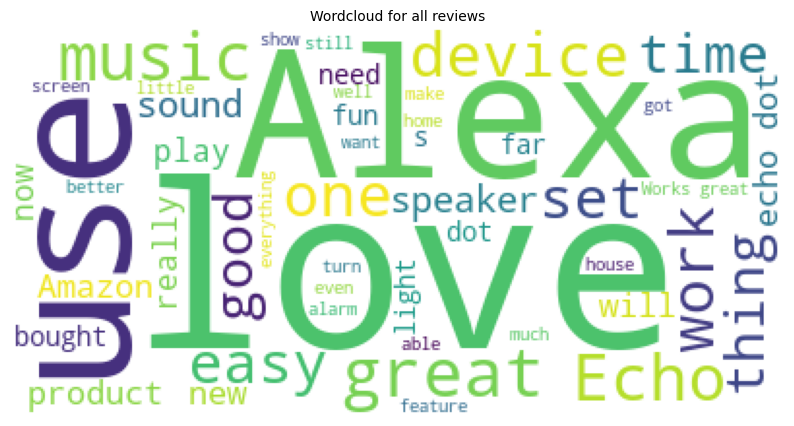

In [336]:
#combining all the reviews 
reviews = " ".join([review for review in df['verified_reviews']])
#initializing wordcloud object
wc = WordCloud(background_color='white',max_words=50)
#Generating and plotting word cloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title("Wordcloud for all reviews",fontsize=10)
plt.axis('off')
plt.show()

In [337]:
# Joining the reviews with respect to feedback category and splitting them to words
neg_reviews=" ".join([review for review in df[df['feedback']==0]['verified_reviews']])
neg_reviews=neg_reviews.lower().split()

pos_reviews=" ".join([review for review in df[df['feedback']==1]['verified_reviews']])
pos_reviews=pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only

unique_neg = [x for x in neg_reviews if x not in pos_reviews]
unique_neg = " ".join(unique_neg)
unique_pos = [x for x in pos_reviews if x not in neg_reviews]
unique_pos = " ".join(unique_pos)

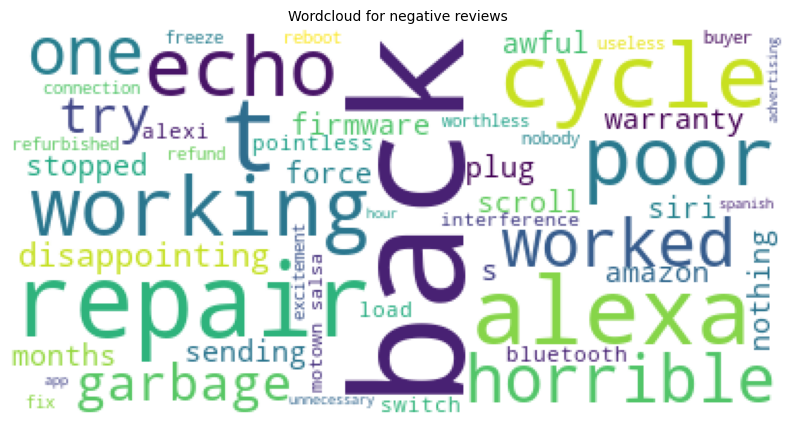

In [338]:
wc = WordCloud(background_color='white',max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_neg))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

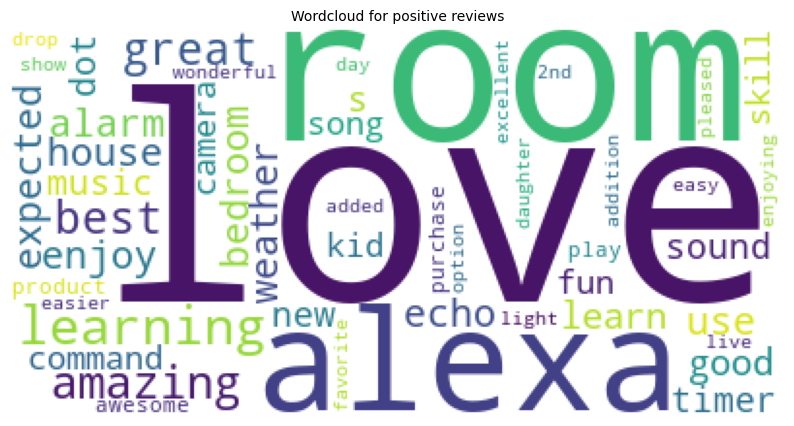

In [339]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_pos))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [342]:
corpus = []
stemmer = PorterStemmer()
for i in range(0,df.shape[0]):
    review = re.sub('[^a-zA-Z]',' ',df.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [343]:
cv = CountVectorizer(max_features=2500)

X = cv.fit_transform(corpus).toarray()
y = df['feedback'].values

In [344]:
#Saving count vectorizer
pickle.dump(cv,open('countVectorizer.pkl','wb'))

In [345]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


### Splitting the data into training and testing data 

In [347]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2204, 2500)
y train: (2204,)
X test: (945, 2500)
y test: (945,)


scaling X_train and X_test so that values are between 0 and 1

In [349]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [350]:
pickle.dump(scaler,open('scaler.pkl','wb'))

## Random Forest  

In [352]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [353]:
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 0.9945553539019963
Testing Accuracy : 0.9417989417989417


In [354]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [355]:
#Confusion Matrix
cm = confusion_matrix(y_test,y_preds)

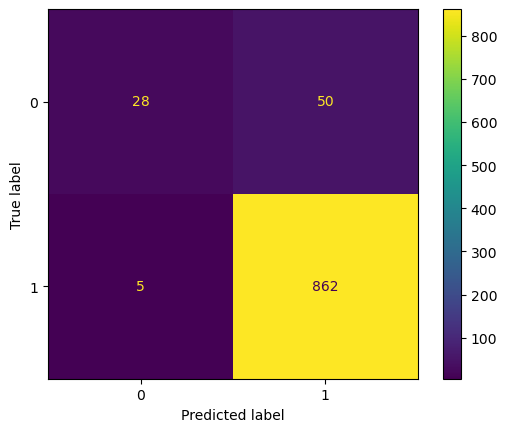

In [356]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

#### K fold cross-validation

In [358]:
accuracies = cross_val_score(estimator=model_rf,X=X_train_scl, y=y_train,cv=10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9314870423693954
Standard Variance : 0.008970486080155533


In [359]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [360]:
cv_object = StratifiedKFold(n_splits=2)
grid_search=GridSearchCV(estimator=model_rf,param_grid=params,cv=cv_object,verbose=0,return_train_score=True)
grid_search.fit(X_train_scl,y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [361]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameters: {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 12, 'n_estimators': 300}
Best Accuracy: 0.9228675136116152


In [467]:
pickle.dump(model_rf, open('model_rf.pkl', 'wb'))

## XgBoost

In [363]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [364]:
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 0.9718693284936479
Testing Accuracy : 0.9375661375661376


In [365]:
y_preds = model_xgb.predict(X_test)

In [366]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 35  43]
 [ 18 849]]


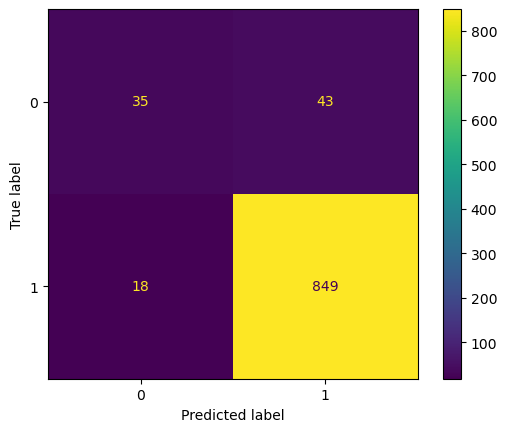

In [367]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [368]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('model_xgb.pkl', 'wb'))

## Decision Tree Classifier

In [370]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl,y_train)

DecisionTreeClassifier()

In [371]:
#Accuracy
print("Training Accuracy: ",model_dt.score(X_train_scl,y_train))
print("Testing Accuracy: ",model_dt.score(X_test_scl,y_test))

Training Accuracy:  0.9945553539019963
Testing Accuracy:  0.9153439153439153


In [372]:
y_preds=model_dt.predict(X_test)

In [373]:

#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 39  39]
 [ 94 773]]


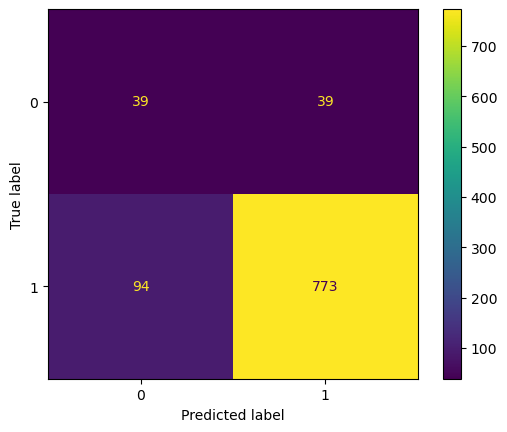

In [374]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [469]:
pickle.dump(model_dt, open('model_dt.pkl', 'wb'))